In [58]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F

In [59]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [60]:
len(words)

32033

In [61]:
# Vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
#s = tuple(enumerate(chars))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [62]:
# Build the dataset
block_size = 3 # Context length: how many characters do we take to predict the next one.

def build_dataset(words):
    x, y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return x, y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

xtr,  ytr  = build_dataset(words[:n1])   # 80% - Training Split
xdev, ydev = build_dataset(words[n1:n2]) # 10% - Dev/Validation Split
xte,  yte  = build_dataset(words[n2:])   # 10% - Test Split



torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [79]:
# MLP Revisited

n_embd = 10     # The dimensionality of the character embedding vectors
n_hidden = 200  # The number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
c = torch.randn((vocab_size, n_embd),             generator=g)
w1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3)/((n_embd * block_size)**0.5))
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
w2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)

bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.ones(1, n_hidden)


parameters = [c, w1, w2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [81]:
# Mini batch example - Randomly use the input

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Mini batch construct
    ix = torch.randint(0, xtr.shape[0], (batch_size,), generator=g)
    xb, yb = xtr[ix], ytr[ix] # Batch x, y
    
    #Forward Pass
    emb = c[xb]                           # embade the char into vectors - emb.shape #-- [32, 3, 2]
    embcat = emb.view(emb.shape[0], -1)   # Concatenate the vectors - Same as (emb.view(-1, 30))
    
    #linear Layer
    hpreact = embcat @ w1 #+ b1 #(gets deducted by next two lines)   # hidden layer pre-activation
    
    # Batch Norm Layer
    #------------------------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * ((hpreact - bnmeani)/ bnstdi) + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi    
    #------------------------------------------------------------------------------
    
    # Non-linearity
    h = torch.tanh(hpreact)               # hidden layer h.shape #--[32, 100]
    logits = h @ w2 + b2                  # logits.shape # -- [32, 27]
    loss = F.cross_entropy(logits, yb)

    #Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        #print(p.grad)
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:  # print every interval of 10k steps
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 2.3610
  10000/ 200000: 1.9538
  20000/ 200000: 1.9812
  30000/ 200000: 2.2792
  40000/ 200000: 2.2866
  50000/ 200000: 2.0597
  60000/ 200000: 2.1078
  70000/ 200000: 2.1645
  80000/ 200000: 2.2722
  90000/ 200000: 2.0733
 100000/ 200000: 1.8874
 110000/ 200000: 2.2675
 120000/ 200000: 1.9679
 130000/ 200000: 2.4050
 140000/ 200000: 1.7024
 150000/ 200000: 2.2674
 160000/ 200000: 2.3448
 170000/ 200000: 1.9653
 180000/ 200000: 1.9531
 190000/ 200000: 1.9442


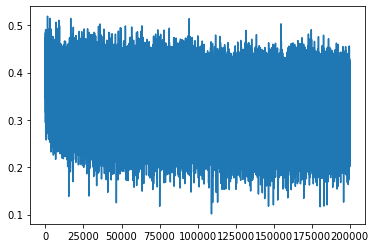

In [82]:
plt.plot(lossi)

In [49]:
# Caliberate the batch norm at end of the training

with torch.no_grad():
    # Pass the training set
    emb = c[xtr]                                  # emb.shape #-- [32, 3, 2] --> [N, block_size, n_embd]
    embcat = emb.view(emb.shape[0], -1)         # Concatenate the vectors --> (N, block_size * n_embd)
    hpreact = embcat @ w1 + b1
    
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [83]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (xtr, ytr),
        'val'  : (xdev, ydev),
        'test' : (xte, yte)
    } [split]
    emb = c[x]                                  # emb.shape #-- [32, 3, 2] --> [N, block_size, n_embd]
    embcat = emb.view(emb.shape[0], -1)         # Concatenate the vectors --> (N, block_size * n_embd)
    hpreact = embcat @ w1 + b1
    hpreact = bngain * ((hpreact - bnmean_running) / (bnstd_running)) + bnbias
    h = torch.tanh(hpreact)                     # h.shape #--[N, n_hidden]
    logits = h @ w2 + b2                        # (N, vocab-size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')
split_loss('test')

train 2.0687294006347656
val 2.1073553562164307
test 2.1064441204071045


In [24]:
# Original
train 2.1294455528259277
val 2.173779249191284
test 2.1665380001068115


# After
train 2.0376641750335693
val 2.1069893836975098
test 2.1049904823303223

# Batch norm layer
train 2.066879987716675
val 2.1049392223358154
test 2.106653928756714


#
train 2.066879987716675
val 2.1050217151641846
test 2.1066231727600098

In [84]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        #Forward pass the neural net
        emb = c[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        
        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        
        # shift the context and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

briahgmnazzierstel.
fyllarithruthjdrnez.
shlyadarliingmikshaldde.
sustanardelyz.
marquamnyshdumrithghnestle.
jewtdvi.
xibellanushbn.
dariyahubmels.
kaylahshmyah.
hzannahshbuqunzalkl.
junamthrisss.
jaisgmnghdvi.
quinyobhgbprix.
sumushmarhmaerlynd.
qinfelvshlwaldahikthrishtwn.
gsizahmmitgftrvillivia.
ten.
riefhnlix.
xavonshtylikelsgbbbigvtgttri.
bdgihzirrlethjaymphreniahgulftrvicaisgmovrettaydn.
